In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
!apt-get install imutils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package imutils


In [12]:
import numpy as np 
import pandas as pd
import random as rd
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.metrics import accuracy
from keras.applications.vgg16 import VGG16

#setting seed for reproducability
from numpy.random import seed
seed(25)
tf.random.set_seed(50)

In [13]:
data = [] #creating a list for images
paths = [] #creating a list for paths
labels = [] #creating a list to put our 0 or 1 labels

#staring with the images that have tumors
for r, d, f in os.walk(r'../input/brain-mri-images-for-brain-tumor-detection/yes'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        labels.append(1)

#now working with the images with no tumors        
paths = []
for r, d, f in os.walk(r"../input/brain-mri-images-for-brain-tumor-detection/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))
for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        labels.append(0)
        
data = np.array(data)
data.shape

labels = np.array(labels)
labels = labels.reshape(139,1)

print('data shape is:', data.shape)
print('labels shape is:', labels.shape)

data shape is: (139, 128, 128, 3)
labels shape is: (139, 1)


In [14]:
print(data.shape)

(139, 128, 128, 3)


In [15]:
print(np.max(data))
print(np.min(data))

255
0


In [16]:
#reducing the data to between 1 and 0
data = data / 255.00
#getting the max of the array
print(np.max(data))
#getting the min of the array
print(np.min(data))

1.0
0.0


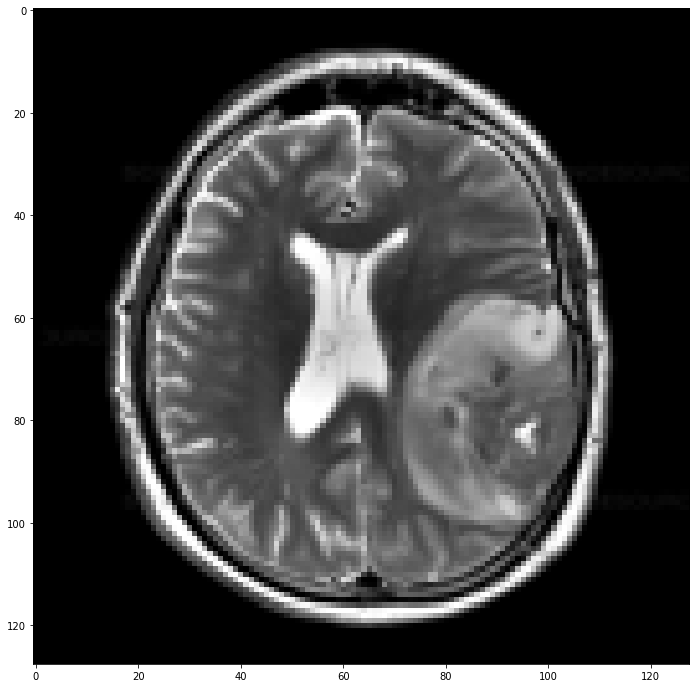

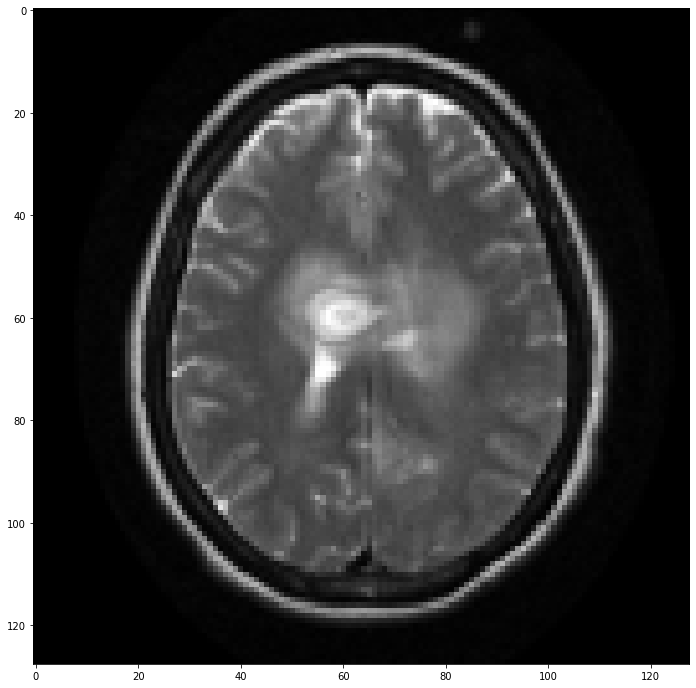

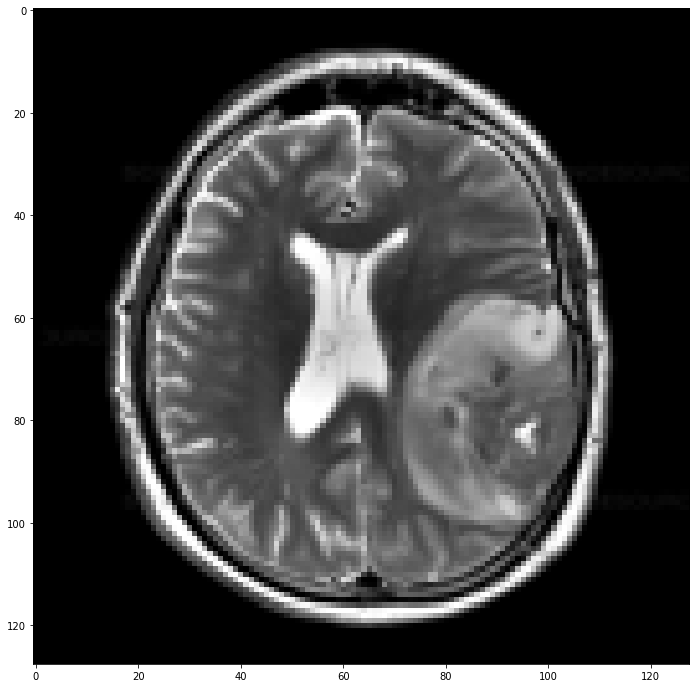

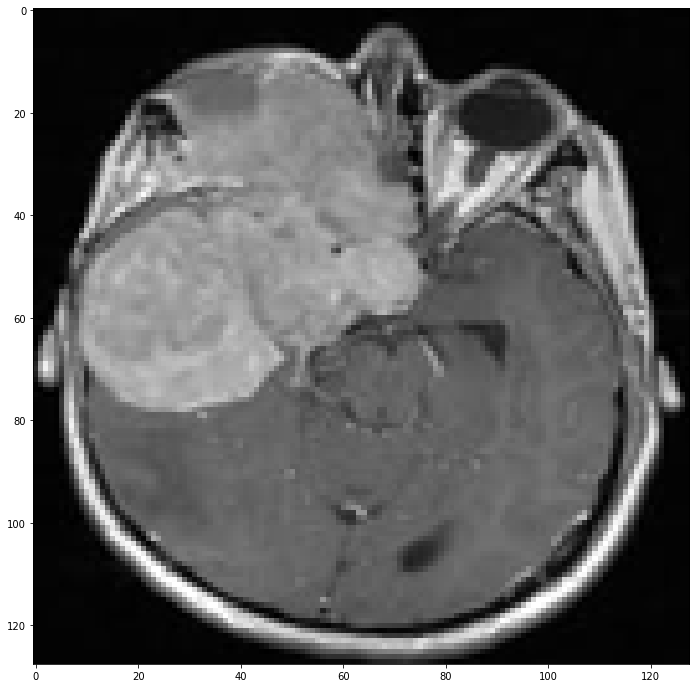

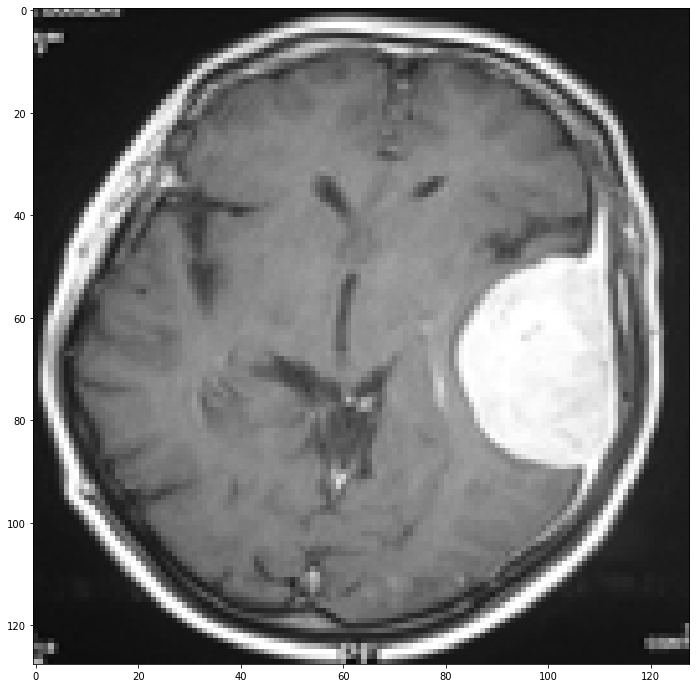

In [17]:
for i in range(5):
    fig = plt.figure(figsize=(70,70))
    plt.subplot(5,5,i+1)
    image = plt.imshow(data[i])
    plt.show(image)

In [18]:
x_train,x_test,y_train,y_test = train_test_split(data, labels, test_size=0.3, shuffle=True, random_state=7)

In [19]:
print("shape of our training data:",x_train.shape)
print("shape of our training labels:",y_train.shape)
print("shape of our test data:",x_test.shape)
print("shape of our test labels:",y_test.shape)

shape of our training data: (97, 128, 128, 3)
shape of our training labels: (97, 1)
shape of our test data: (42, 128, 128, 3)
shape of our test labels: (42, 1)


In [20]:
model = keras.Sequential([
    
    layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding='same', input_shape=[128, 128, 3]),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dropout(.25),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])

2022-10-03 06:18:30.983522: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       1

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#including early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [23]:
history = model.fit(
    x = x_train,
    y = y_train,
    validation_data= (x_test,y_test),
    batch_size = 64,
    epochs=200,
    callbacks=[early_stopping],
    verbose=(2),
)

2022-10-03 06:19:52.080669: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
2/2 - 3s - loss: 0.6920 - accuracy: 0.5155 - val_loss: 0.6946 - val_accuracy: 0.4286
Epoch 2/200
2/2 - 1s - loss: 0.6908 - accuracy: 0.5361 - val_loss: 0.6942 - val_accuracy: 0.4286
Epoch 3/200
2/2 - 1s - loss: 0.6909 - accuracy: 0.5361 - val_loss: 0.6938 - val_accuracy: 0.4286
Epoch 4/200
2/2 - 1s - loss: 0.6881 - accuracy: 0.5258 - val_loss: 0.6932 - val_accuracy: 0.4286
Epoch 5/200
2/2 - 1s - loss: 0.6872 - accuracy: 0.5361 - val_loss: 0.6926 - val_accuracy: 0.4286
Epoch 6/200
2/2 - 1s - loss: 0.6873 - accuracy: 0.5361 - val_loss: 0.6920 - val_accuracy: 0.4286
Epoch 7/200
2/2 - 1s - loss: 0.6872 - accuracy: 0.5361 - val_loss: 0.6914 - val_accuracy: 0.4286
Epoch 8/200
2/2 - 1s - loss: 0.6861 - accuracy: 0.5361 - val_loss: 0.6907 - val_accuracy: 0.4286
Epoch 9/200
2/2 - 1s - loss: 0.6830 - accuracy: 0.5361 - val_loss: 0.6899 - val_accuracy: 0.4286
Epoch 10/200
2/2 - 1s - loss: 0.6831 - accuracy: 0.5361 - val_loss: 0.6892 - val_accuracy: 0.4286
Epoch 11/200
2/2 - 1s - loss:

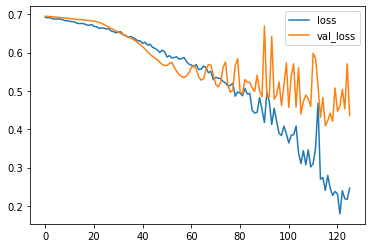

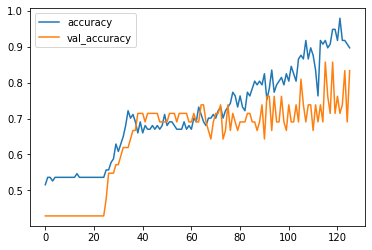

In [24]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss','val_loss']].plot()
history_frame.loc[:, ['accuracy','val_accuracy']].plot();

In [25]:
pred = model.predict(x_test)

for i in range(len(pred)):
    if pred[i] > 0.5:
        pred[i] = 1
    else:
        pred[i] = 0
     
pred = pred.astype(int)

In [26]:
classification_report(y_test, pred)

'              precision    recall  f1-score   support\n\n           0       0.88      0.88      0.88        24\n           1       0.83      0.83      0.83        18\n\n    accuracy                           0.86        42\n   macro avg       0.85      0.85      0.85        42\nweighted avg       0.86      0.86      0.86        42\n'

In [27]:
model = keras.Sequential([
    
    preprocessing.RandomFlip('horizontal'), # flip left-to-right
    
    layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding='same', input_shape=[128, 128, 3]),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dropout(.25),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])

In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#including early stopping to revent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=30,
    min_delta=0.001,
    restore_best_weights=True,
)

In [37]:
history = model.fit(
    x = x_train,
    y = y_train,
    validation_data= (x_test,y_test),
    batch_size = 64,
    epochs=200,
    callbacks=[early_stopping],
    verbose=(2),
)

Epoch 1/200
2/2 - 1s - loss: 0.1532 - accuracy: 0.9485 - val_loss: 0.4386 - val_accuracy: 0.8095
Epoch 2/200
2/2 - 1s - loss: 0.0941 - accuracy: 0.9691 - val_loss: 0.4649 - val_accuracy: 0.8095
Epoch 3/200
2/2 - 1s - loss: 0.1332 - accuracy: 0.9485 - val_loss: 0.3755 - val_accuracy: 0.8333
Epoch 4/200
2/2 - 2s - loss: 0.0844 - accuracy: 0.9897 - val_loss: 0.4044 - val_accuracy: 0.8333
Epoch 5/200
2/2 - 1s - loss: 0.0865 - accuracy: 0.9897 - val_loss: 0.3622 - val_accuracy: 0.8571
Epoch 6/200
2/2 - 1s - loss: 0.1054 - accuracy: 0.9588 - val_loss: 0.4192 - val_accuracy: 0.8333
Epoch 7/200
2/2 - 1s - loss: 0.0942 - accuracy: 0.9897 - val_loss: 0.4440 - val_accuracy: 0.8333
Epoch 8/200
2/2 - 1s - loss: 0.0850 - accuracy: 0.9794 - val_loss: 0.3240 - val_accuracy: 0.8810
Epoch 9/200
2/2 - 1s - loss: 0.1094 - accuracy: 0.9691 - val_loss: 0.5364 - val_accuracy: 0.8095
Epoch 10/200
2/2 - 1s - loss: 0.1007 - accuracy: 0.9588 - val_loss: 0.4498 - val_accuracy: 0.8333
Epoch 11/200
2/2 - 1s - loss:

In [38]:
pred = model.predict(x_test)

for i in range(len(pred)):
    if pred[i] > 0.5:
        pred[i] = 1
    else:
        pred[i] = 0

pred = pred.astype(int)

In [39]:
classification_report(y_test, pred)

'              precision    recall  f1-score   support\n\n           0       0.95      0.83      0.89        24\n           1       0.81      0.94      0.87        18\n\n    accuracy                           0.88        42\n   macro avg       0.88      0.89      0.88        42\nweighted avg       0.89      0.88      0.88        42\n'